# Penyeimbangan Data

## 1. Download dataset ecoli dari UCI https://archive.ics.uci.edu/dataset/39/ecoli



## 2. Simpan didatabase MySQL

berikut adalah tabel dataset:
![Tabel Iris di PostgreSQL](_build/html/_static/images/ecoli.png)

## 2.1 Import library

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE
from collections import Counter
import seaborn as sns

ModuleNotFoundError: No module named 'imblearn'

## 2.2 load dataset dari MYSQL menggunakan sqlalchemy

In [70]:
engine = create_engine("mysql+pymysql://root:@localhost/ecoli")
df = pd.read_sql("SELECT * FROM ecoli;", engine) 

## Distribusi Kelas

DATA AWAL ECOLI DATASET
Jumlah data: 336
Jumlah fitur: 7
Jumlah kelas: 8


Preview data (5 baris pertama):
         name   mcg   gvh   lip  chg   aac  alm1  alm2 class
0   AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
1  ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
2  ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
3  ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp
4   ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35    cp


Statistik deskriptif data:
              mcg         gvh         lip         chg         aac        alm1  \
count  336.000000  336.000000  336.000000  336.000000  336.000000  336.000000   
mean     0.500060    0.500000    0.495476    0.501488    0.500030    0.500179   
std      0.194634    0.148157    0.088495    0.027277    0.122376    0.215751   
min      0.000000    0.160000    0.480000    0.500000    0.000000    0.030000   
25%      0.340000    0.400000    0.480000    0.500000    0.420000    0.330000   
50%      0.5

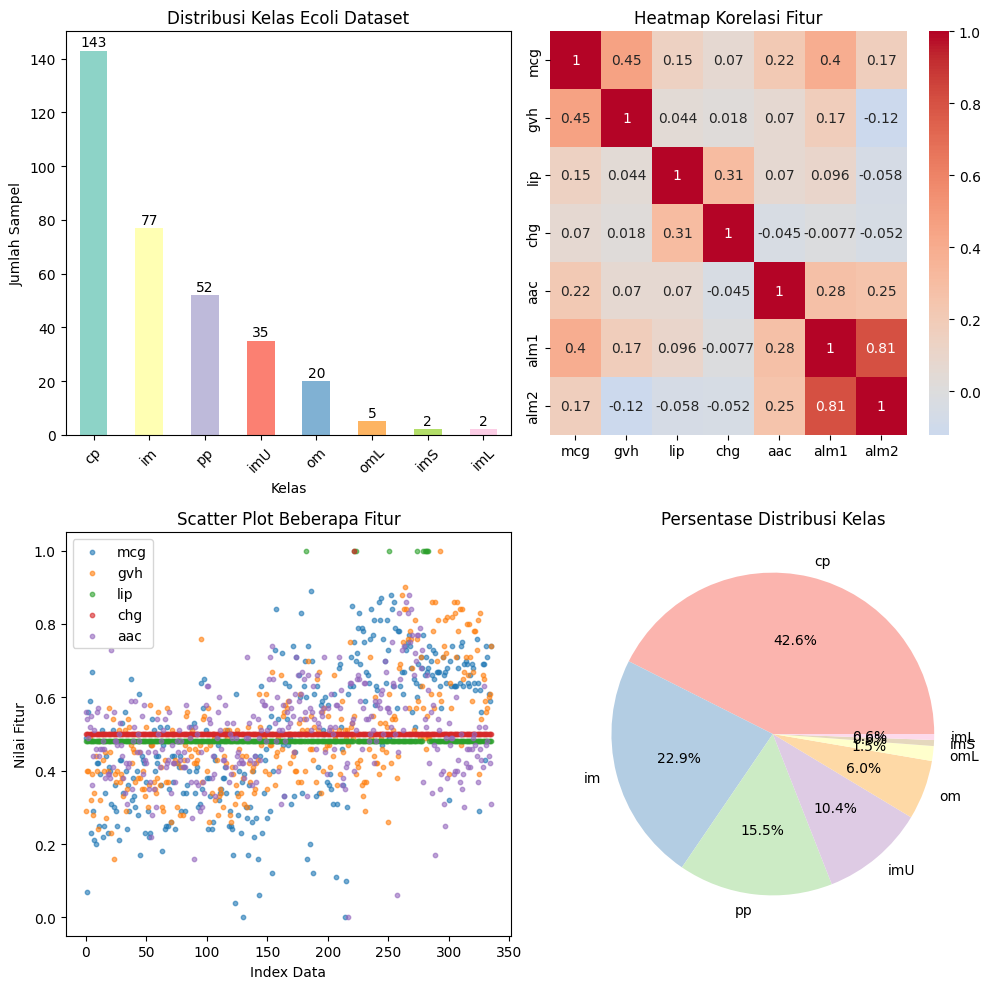

In [71]:
# 2. Tampilkan data awal dalam bentuk tabel
print("=" * 60)
print("DATA AWAL ECOLI DATASET")
print("=" * 60)
print(f"Jumlah data: {len(df)}")
print(f"Jumlah fitur: {len(df.columns) - 2}")  # excluding name and class
print(f"Jumlah kelas: {df['class'].nunique()}")
print("\n")

# Tampilkan preview data
print("Preview data (5 baris pertama):")
print(df.head())
print("\n")

# Tampilkan informasi statistik
print("Statistik deskriptif data:")
print(df.drop(columns=['name', 'class']).describe())
print("\n")

# Tampilkan distribusi kelas
print("Distribusi kelas:")
class_distribution = df['class'].value_counts()
print(class_distribution)
print("\n")

# 3. Visualisasi data awal
plt.figure(figsize=(15, 10))

# Subplot 1: Distribusi kelas (Bar plot)
plt.subplot(2, 3, 1)
class_distribution.plot(kind='bar', color=plt.cm.Set3(np.arange(len(class_distribution))))
plt.title('Distribusi Kelas Ecoli Dataset')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
for i, v in enumerate(class_distribution):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Subplot 2: Heatmap korelasi
plt.subplot(2, 3, 2)
numeric_df = df.drop(columns=['name', 'class'])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap Korelasi Fitur')

# Subplot 4: Pairplot untuk beberapa fitur (maks 5 fitur agar tidak terlalu padat)
plt.subplot(2, 3, 4)
if len(numeric_df.columns) > 5:
    sample_features = numeric_df.columns[:5]  # Ambil 5 fitur pertama
else:
    sample_features = numeric_df.columns
    
for i, feature in enumerate(sample_features):
    plt.scatter(range(len(df)), df[feature], alpha=0.6, label=feature, s=10)
plt.title('Scatter Plot Beberapa Fitur')
plt.xlabel('Index Data')
plt.ylabel('Nilai Fitur')
plt.legend()

# Subplot 5: Pie chart distribusi kelas
plt.subplot(2, 3, 5)
plt.pie(class_distribution.values, labels=class_distribution.index, 
        autopct='%1.1f%%', colors=plt.cm.Pastel1(np.arange(len(class_distribution))))
plt.title('Persentase Distribusi Kelas')


plt.tight_layout()
plt.show()

## 3. Tampilkan data dalam scatter plot  menggunakan PCA. PCA mentransformasi data menjadi dimensi rendah (2)

3. Pisahkan fitur dan label

In [72]:
X = df.drop(columns=["name", "class"])
y = df["class"]

4. Transform data dan tampilkan scatter plot menggunakan PCA

Explained variance ratio (PC1, PC2): [0.31508933 0.20874152]


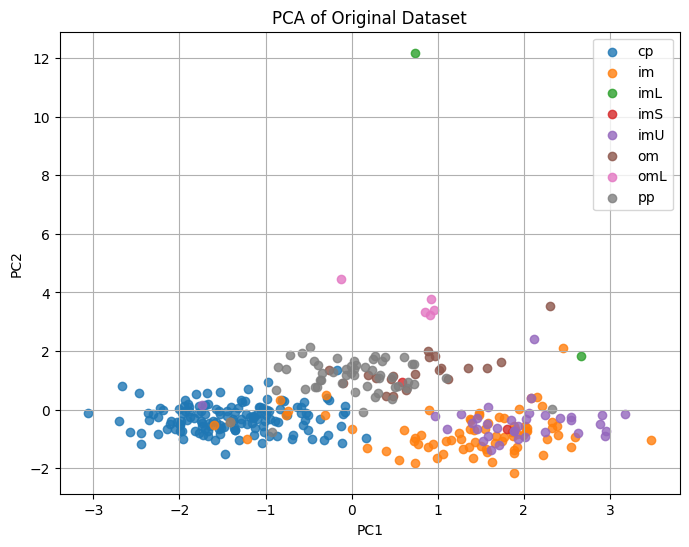

In [73]:
# 1. Normalisasi
X_scaled = StandardScaler().fit_transform(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. PCA (2 komponen)
pca = PCA(n_components=2)
X_r = pca.fit_transform(X_scaled)

# 3. Tampilkan explained variance
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# 4. Plot hasil PCA
plt.figure(figsize=(8,6))
for target_name in np.unique(y):
    plt.scatter(
        X_r[y == target_name, 0], 
        X_r[y == target_name, 1], 
        alpha=0.8, 
        label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Original Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

## 4. Lakukan penyeimbangan data menggunakan ADASYN


In [74]:
print("Distribusi kelas sebelum ADASYN:")
print(f"{sorted(Counter(y).items())}")

nt = X
ns = y
class_counts = Counter(y)
temp = sorted(class_counts.values())  
print(f"Sorted counts untuk iterasi: {temp}")

for i in range(0, 7):
    n = max(1, temp[i] - 1)  
    
    print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")
    
    try:
        nt, ns = ADASYN(n_neighbors=n, sampling_strategy='minority').fit_resample(nt, ns)
        print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")

Distribusi kelas sebelum ADASYN:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]
Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Iterasi 1: menggunakan k_neighbors=1
Hasil iterasi 1: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 2: menggunakan k_neighbors=1
Hasil iterasi 2: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 3: menggunakan k_neighbors=4
Hasil iterasi 3: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 143), ('pp', 52)]

Iterasi 4: menggunakan k_neighbors=19
Hasil iterasi 4: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 5: menggunakan k_neighbors=34
Hasil iterasi 5: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 146), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 

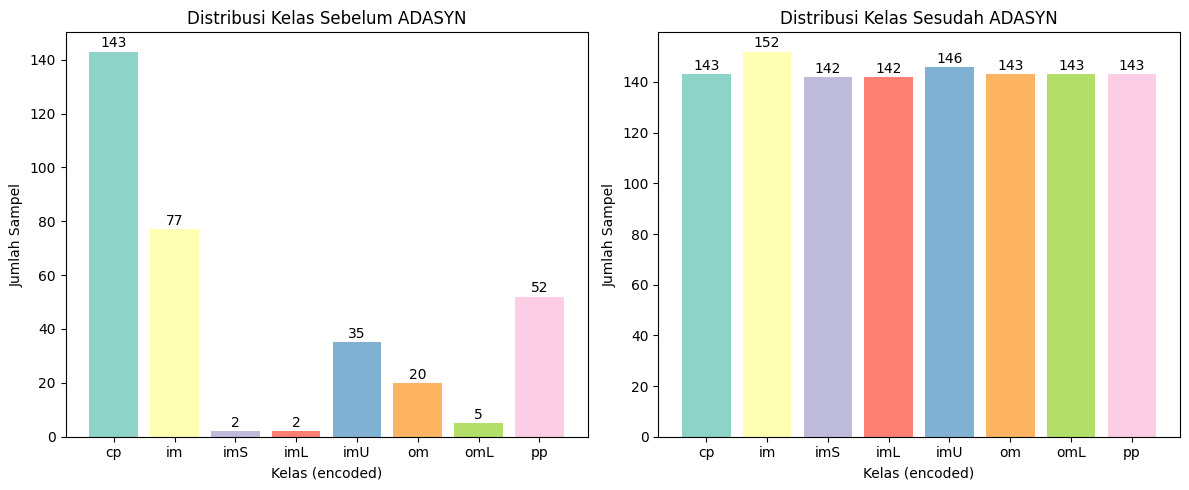

In [75]:
class_distribution_before = class_counts
class_distribution_after = Counter(ns)
# 4. Visualisasi diagram batang
plt.figure(figsize=(12, 5))

# Sebelum ADASYN
plt.subplot(1, 2, 1)
plt.bar(class_distribution_before.keys(),
        class_distribution_before.values(),
        color=plt.cm.Set3(np.arange(len(class_distribution_before))))
plt.title("Distribusi Kelas Sebelum ADASYN")
plt.xlabel("Kelas (encoded)")
plt.ylabel("Jumlah Sampel")
for i, (k, v) in enumerate(class_distribution_before.items()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Sesudah ADASYN
plt.subplot(1, 2, 2)
plt.bar(class_distribution_after.keys(),
        class_distribution_after.values(),
        color=plt.cm.Set3(np.arange(len(class_distribution_after))))
plt.title("Distribusi Kelas Sesudah ADASYN")
plt.xlabel("Kelas (encoded)")
plt.ylabel("Jumlah Sampel")
for i, (k, v) in enumerate(class_distribution_after.items()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Menggunakan SMOTE

In [76]:
class_distribution_before = df['class'].value_counts()

smote = SMOTE(k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

class_distribution_after = Counter(y_resampled)

print("✅ SMOTE berhasil")
print("Sebelum:", class_distribution_before)
print("Sesudah:", class_distribution_after)

✅ SMOTE berhasil
Sebelum: class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64
Sesudah: Counter({'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143})


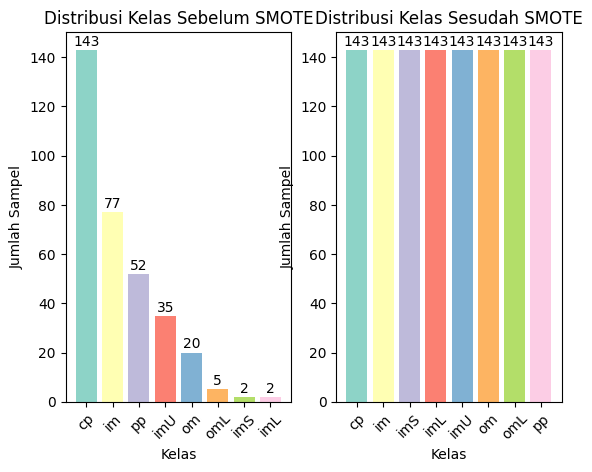

In [77]:
# Subplot 1: Sebelum SMOTE
plt.subplot(1, 2, 1)
plt.bar(class_distribution_before.index,
        class_distribution_before.values,
        color=plt.cm.Set3(np.arange(len(class_distribution_before))))
plt.title('Distribusi Kelas Sebelum SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
for i, (k, v) in enumerate(class_distribution_before.items()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

# Subplot 2: Sesudah SMOTE
plt.subplot(1, 2, 2)
plt.bar(class_distribution_after.keys(),
        class_distribution_after.values(),
        color=plt.cm.Set3(np.arange(len(class_distribution_after))))
plt.title('Distribusi Kelas Sesudah SMOTE')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
for i, (k, v) in enumerate(class_distribution_after.items()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')


## Visualisasi setelah Oversampling

Explained variance ratio setelah SMOTE (PC1, PC2): [0.28543105 0.24639916]


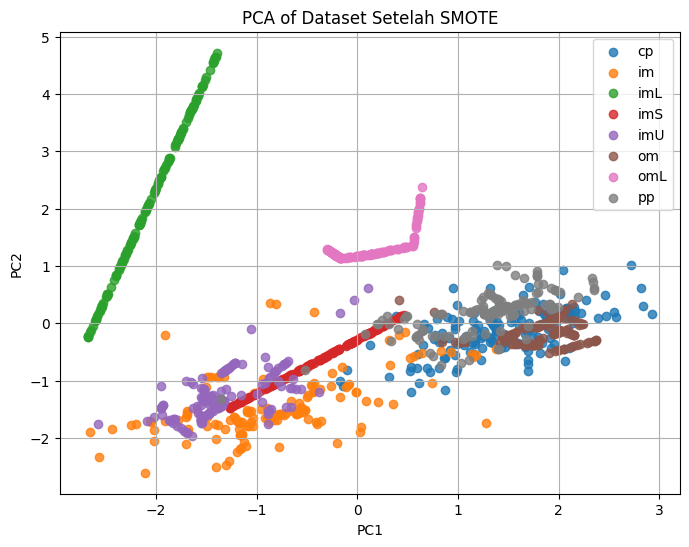

In [78]:
# 1. Normalisasi ulang
X_resampled_scaled = StandardScaler().fit_transform(X_resampled)

# 2. PCA (2 komponen)
pca_res = PCA(n_components=2)
X_r_res = pca_res.fit_transform(X_resampled_scaled)

# 3. Tampilkan explained variance
print("Explained variance ratio setelah SMOTE (PC1, PC2):", pca_res.explained_variance_ratio_)

# 4. Plot hasil PCA
plt.figure(figsize=(8,6))
for target_name in np.unique(y_resampled):
    plt.scatter(
        X_r_res[y_resampled == target_name, 0], 
        X_r_res[y_resampled == target_name, 1], 
        alpha=0.8, 
        label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Dataset Setelah SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()


## 5. Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya

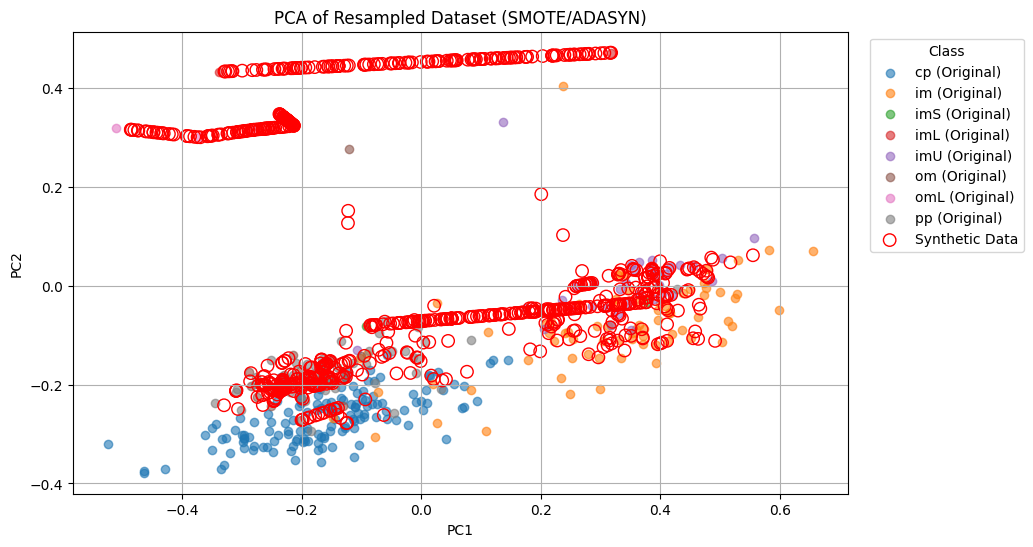

In [79]:
# --- 1. PCA (2 komponen) ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_resampled)

# --- 2. Buat DataFrame hasil PCA ---
data_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
data_pca['Class'] = y_resampled

# Tandai data asli vs synthetic
n_original = len(X_scaled)   # jumlah data sebelum SMOTE
data_pca['Type'] = ["Original"] * n_original + ["Synthetic"] * (len(data_pca) - n_original)

# --- 3. Plot hasil PCA ---
plt.figure(figsize=(10,6))

# Plot data asli per kelas
for label in data_pca['Class'].unique():
    subset = data_pca[(data_pca['Class'] == label) & (data_pca['Type'] == "Original")]
    plt.scatter(
        subset['PC1'], subset['PC2'],
        label=f"{label} (Original)", alpha=0.6
    )

# Plot data synthetic dengan marker khusus
synthetic = data_pca[data_pca['Type'] == "Synthetic"]
plt.scatter(
    synthetic['PC1'], synthetic['PC2'],
    facecolors='none', edgecolors='red', marker='o', s=80, label="Synthetic Data"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Resampled Dataset (SMOTE/ADASYN)")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid()
plt.show()
